In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')

In [3]:
five_star_ratings_index = df.index[df['Rating']==5].tolist()

In [4]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')
df = df.drop(index=five_star_ratings_index)
#Great! We are doing good so far.
df = df.reset_index()
df = df.drop(columns=['index'])
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"excellent staff, housekeeping quality hotel ch...",4
4,"poor value stayed monaco seattle july, nice ho...",2
...,...,...
11432,not impressed unfriendly staff checked asked h...,2
11433,great location price view hotel great quick pl...,4
11434,"ok just looks nice modern outside, desk staff ...",2
11435,hotel theft ruined vacation hotel opened sept ...,1


In [5]:
#Also let us add a sentiment column to our modified dataframe

df_sentiment = pd.DataFrame(data = np.zeros(11437), columns=['Sentiment'],dtype='int64')
df_model = pd.concat([df,df_sentiment], axis = 1)

#We need to update the sentiment. If rating is 4 sentiment will be positive = 1

for i in range(11437):
  if df_model.at[i,'Rating']==4:
    df_model.at[i,'Sentiment']=1

df_model

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,0
3,"excellent staff, housekeeping quality hotel ch...",4,1
4,"poor value stayed monaco seattle july, nice ho...",2,0
...,...,...,...
11432,not impressed unfriendly staff checked asked h...,2,0
11433,great location price view hotel great quick pl...,4,1
11434,"ok just looks nice modern outside, desk staff ...",2,0
11435,hotel theft ruined vacation hotel opened sept ...,1,0


In [6]:
df_sample = df_model.sample(n=1000, axis=0,random_state=69)
df_sample = df_sample.reset_index(drop=True)
df_sample

,Review,Rating,Sentiment
0,"good place stay, stayed week july 4th holiday,...",4,1
1,good location overpriced hotel boston hotels o...,3,0
2,not fully satisfied husband stayed goodwood pa...,3,0
3,second time hotel didnt disapoint staying hote...,4,1
4,"inclusive runs guaranteed, party 6 77 yr. old ...",1,0
...,...,...,...
995,"great location location best thing hotel, just...",4,1
996,beware food water service riu tiano experience...,1,0
997,great place quaint hotel middle las ramblas pl...,4,1
998,ummmm just returned long weekend not sure star...,2,0


In [7]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\koush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\koush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
def clean_review(review, stemmer = SnowballStemmer('english'), stop_words = set(stopwords.words('english'))):

  words = word_tokenize(review.lower())
  
  filtered_words = []
  for word in words:
      if word not in stop_words and word.isalpha(): #(isalphabet)
          stemmed_word = stemmer.stem(word)
          filtered_words.append(stemmed_word)
  return filtered_words

stemmed_nested_list = df_sample.Review.apply(clean_review) #applied this to the sample!
print(stemmed_nested_list)

0      [good, place, stay, stay, week, juli, holiday,...
1      [good, locat, overpr, hotel, boston, hotel, ov...
2      [fulli, satisfi, husband, stay, goodwood, park...
3      [second, time, hotel, didnt, disapoint, stay, ...
4      [inclus, run, guarante, parti, old, adult, adu...
                             ...                        
995    [great, locat, locat, best, thing, hotel, las,...
996    [bewar, food, water, servic, riu, tiano, exper...
997    [great, place, quaint, hotel, middl, las, ramb...
998    [ummmm, return, long, weekend, sure, start, po...
999    [great, end, vacat, stay, locat, carniv, cruis...
Name: Review, Length: 1000, dtype: object


In [9]:
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]
unique_words = pd.Series(flat_stemmed_list).value_counts() #It is ordering words from more frequent appearances to less frequent
NUMBER_OF_UNIQUE_WORDs = len(unique_words)
print('Number of unique words:',len(unique_words))

Number of unique words: 7933


In [10]:
#Now I want to associate in a dictionary a word to the number of appearances it has. We do this for the most 700 frequent words
NUMBER_OF_WORDS=700
word_appearances_dict={}
for i in range(NUMBER_OF_WORDS):
  word_appearances_dict[unique_words.index[i]]=unique_words[i]

#Create an ID for every unique word. We create our vocabulary.

word_id_dict = {}

for i in range(len(unique_words)):
  word_id_dict[unique_words.index[i]]=i

#Id to word dictionary
id_word_dict = {v: k for k, v in word_id_dict.items()}

#We convert the words in stemmed nested list to its word ID

stemmed_nested_list = stemmed_nested_list.tolist()
stemmed_nested_list_IDs = []

for sublista in stemmed_nested_list:
  sublista_ID=[]
  for elemento in sublista:
    sublista_ID.append(word_id_dict[elemento])
  stemmed_nested_list_IDs.append(sublista_ID)



In [11]:
#We create the words database

NUMBER_OF_ROWS = 1000 #number of reviews

NUMBER_OF_COLS = NUMBER_OF_WORDS #number of unique words considered
df_words = pd.DataFrame(np.zeros((NUMBER_OF_ROWS, NUMBER_OF_COLS)),dtype ='int64')

df_words

row = 0
for lista in stemmed_nested_list_IDs:
  for elemento in lista:
    if elemento<NUMBER_OF_WORDS:
      df_words.at[row,elemento] =1
  row+=1

df_words

,0,1,2,3,4,5,6,7,8,9,...,690,691,692,693,694,695,696,697,698,699
0,1,1,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,1,0,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,1,1,0,1,1,...,0,0,0,1,0,0,0,0,0,0
3,1,1,1,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
996,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
997,1,0,0,1,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
998,1,1,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [12]:
#Next we will construct our data frames for ML. For rating prediction.

In [13]:
df_model_rating = pd.concat([df_sample.loc[:,['Rating']],df_words], axis = 1)
df_model_rating

,Rating,0,1,2,3,4,5,6,7,8,...,690,691,692,693,694,695,696,697,698,699
0,4,1,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,3,1,1,0,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,1,1,0,1,1,0,1,...,0,0,0,1,0,0,0,0,0,0
3,4,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4,1,0,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
996,1,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
997,4,1,0,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
998,2,1,1,0,1,1,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0


In [14]:
#Creamos todos los sets

def set_reviews(word_id):
    globals()[f"set_reviews_{word_id}"] = set()
    for i in range(1000):
        if df_model_rating.iat[i,word_id+1]==1:
            globals()[f"set_reviews_{word_id}"].add(i)
                 
for i in range(700):
    set_reviews(i)

In [15]:
set_reviews_699 #Ejemplo

{0, 47, 68, 116, 133, 379, 380, 395, 512, 677, 717, 780, 789, 885}

In [16]:
#Las metemos todas en una lista indexada


In [17]:
# import random ###Solo para mostrar funcionamiento
# random.seed(29)
# randomlist = []
# for i in range(0,30):
#   n = random.randint(0,1000)
#   randomlist.append(n)




# max_set=set()
# max_set.add(1)
# max_set.add(2)
# max_set.add(3)
# max_set.add(4)


# WORD_ID=349 #Up to 699
# punctuations_word=set()
# for i in randomlist: #We take a random sample representing the 10% of the total
#   if df_model_rating.iat[i,WORD_ID+1]==1: #word corresponding to 1 is hotel
#     punctuations_word.add(df_model_rating.Rating[i])
#   if punctuations_word==max_set:
#     break;

# punctuations_word

In [18]:
import random
SAMPLE_SIZE=50


random.seed(10)
randomlist = []
for i in range(0,SAMPLE_SIZE):
  n = random.randint(0,999)
  randomlist.append(n)




set_ID_1star = set()
set_ID_2star = set()
set_ID_3star = set()
set_ID_4star = set()

max_set=set()
max_set.add(1)
max_set.add(2)
max_set.add(3)
max_set.add(4)

for i in range(0,700):
  WORD_ID=i #Up to 699
  punctuations_word=set()
  for i in randomlist: #We take a random sample representing the 10% of the total of the rows
    if df_model_rating.iat[i,WORD_ID+1]==1: #word corresponding to 0 is hotel for example
      punctuations_word.add(df_model_rating.Rating[i])
      if 1 in punctuations_word:
        set_ID_1star.add(WORD_ID)
      if 2 in punctuations_word:
        set_ID_2star.add(WORD_ID)
      if 3 in punctuations_word:
        set_ID_3star.add(WORD_ID)
      if 4 in punctuations_word:
        set_ID_4star.add(WORD_ID)
    if punctuations_word==max_set:
      break;

In [19]:
# for index in set_ID_3star:
#   print(id_word_dict[index])

In [20]:
print('Lenght of set 1 is', len(set_ID_1star), 'out of 700')
print('Lenght of set 2 is', len(set_ID_2star), 'out of 700')
print('Lenght of set 3 is', len(set_ID_3star), 'out of 700')
print('Lenght of set 4 is', len(set_ID_4star), 'out of 700')

Lenght of set 1 is 313 out of 700
Lenght of set 2 is 393 out of 700
Lenght of set 3 is 360 out of 700
Lenght of set 4 is 443 out of 700


In [21]:
#Idea: Los nodos serán más importantes acorde a su ID. Cuanto más bajo el ID es más importante el nodo.

#Normalmente los nodos sustantivos importantes van acompañados de nodos adjetivos // o nodos adjetivos importantes van acompañados de nodos sustantivos importantes.
#Así, sería normal que se repitiera la secuencia clean room o tasty food por ejemplo. En ese sentido ambos el sustantivo y el adjetivo compartirán ID cercanos.
#Es por ello que resultaría lógico relacionar las palabras en base a 2 criterios: 1) Que tengan la misma puntuación
#2) Que estén relacionadas en un k-entorno wrt ID (las ID juegan una especia de papel como centralities se podría decir?). Otra idea: k(ID)-entornos!

In [22]:
#Cómo proceder?

#Propongo meter todo en bruto en los grafos y eliminar las aristas pertinentes.

In [23]:
import networkx as nx
G = nx.Graph()

# unique_words_reduced = unique_words[0:700]
# nodos=dict(unique_words_reduced)
# for count, nodo in enumerate(nodos):
#     G.add_node(nodo)

In [24]:
THRESHOLD_1=5 #index_distance
THRESHOLD_2=10 #min_shared_reviews
THRESHOLD_3=15 #max_shared_reviews

edgesColor={}

#for i in G.edges:
    #edgesColor[i]='red'
    
for index in set_ID_1star:
    word=id_word_dict[index]
    for i in set_ID_1star:
        word1=id_word_dict[i]
        if str(word)!=str(word1)and abs(index-i)<THRESHOLD_1 and len(globals()[f"set_reviews_{index}"]&globals()[f"set_reviews_{i}"])>THRESHOLD_2 and len(globals()[f"set_reviews_{index}"]&globals()[f"set_reviews_{i}"])<THRESHOLD_3:
            #G.add_edge([(str(word), str(word1))], color="black")
            G.add_nodes_from([str(word1)],color=[0.7,1.0,1.0]) #skyblue
            G.add_nodes_from([str(word)],color=[0.7,1.0,1.0])
            G.add_edges_from([(str(word), str(word1))], color=[0.8,0,0.4]) 
            #edgesColor[i]='blue'    

            
for index in set_ID_2star:
    word=id_word_dict[index]
    for i in set_ID_2star:
        word1=id_word_dict[i]
        if str(word)!=str(word1) and abs(index-i)<THRESHOLD_1 and len(globals()[f"set_reviews_{index}"]&globals()[f"set_reviews_{i}"])>THRESHOLD_2 and len(globals()[f"set_reviews_{index}"]&globals()[f"set_reviews_{i}"])<THRESHOLD_3:
            #G.add_edge([(str(word), str(word1))],color='black')
            G.add_nodes_from([str(word1)],color=[0.3,0.7,1.0]) #volvet
            G.add_nodes_from([str(word)],color=[0.3,0.7,1.0])
            G.add_edges_from([(str(word), str(word1))],color=[0.8,0,0.4])
            #edgesColor[i]='black'

            
for index in set_ID_3star:
    word=id_word_dict[index]
    for i in set_ID_3star:
        word1=id_word_dict[i]
        if str(word)!=str(word1) and abs(index-i)<THRESHOLD_1 and len(globals()[f"set_reviews_{index}"]&globals()[f"set_reviews_{i}"])>THRESHOLD_2 and len(globals()[f"set_reviews_{index}"]&globals()[f"set_reviews_{i}"])<THRESHOLD_3:
            #G.add_edge([(str(word), str(word1))],color='b')
            G.add_nodes_from([str(word1)],color=[0.4,0.9,0.5]) #green
            G.add_nodes_from([str(word)],color=[0.4,0.9,0.5])
            G.add_edges_from([(str(word), str(word1))],color=[0.8,0,0.4])
            #edgesColor[i]='red'
            #G.add_edge(1,2,color='r',weight=2)
            

for index in set_ID_4star:
    word=id_word_dict[index]
    for i in set_ID_4star:
        word1=id_word_dict[i]
        if str(word)!=str(word1) and abs(index-i)<THRESHOLD_1 and len(globals()[f"set_reviews_{index}"]&globals()[f"set_reviews_{i}"])>THRESHOLD_2 and len(globals()[f"set_reviews_{index}"]&globals()[f"set_reviews_{i}"])<THRESHOLD_3:
            #G.add_edge([(str(word), str(word1))], color="black")
            G.add_nodes_from([str(word1)],color=[0.9,0.4,0.8])
            G.add_nodes_from([str(word)],color=[0.9,0.4,0.8])
            G.add_edges_from([(str(word), str(word1))],color=[0.8,0,0.4]) 
            #edgesColor[i]='green'

In [25]:
#remove_nodes less than 2 degree
low_degree = [n for n, d in G.degree() if d < 2]
G.remove_nodes_from(low_degree)

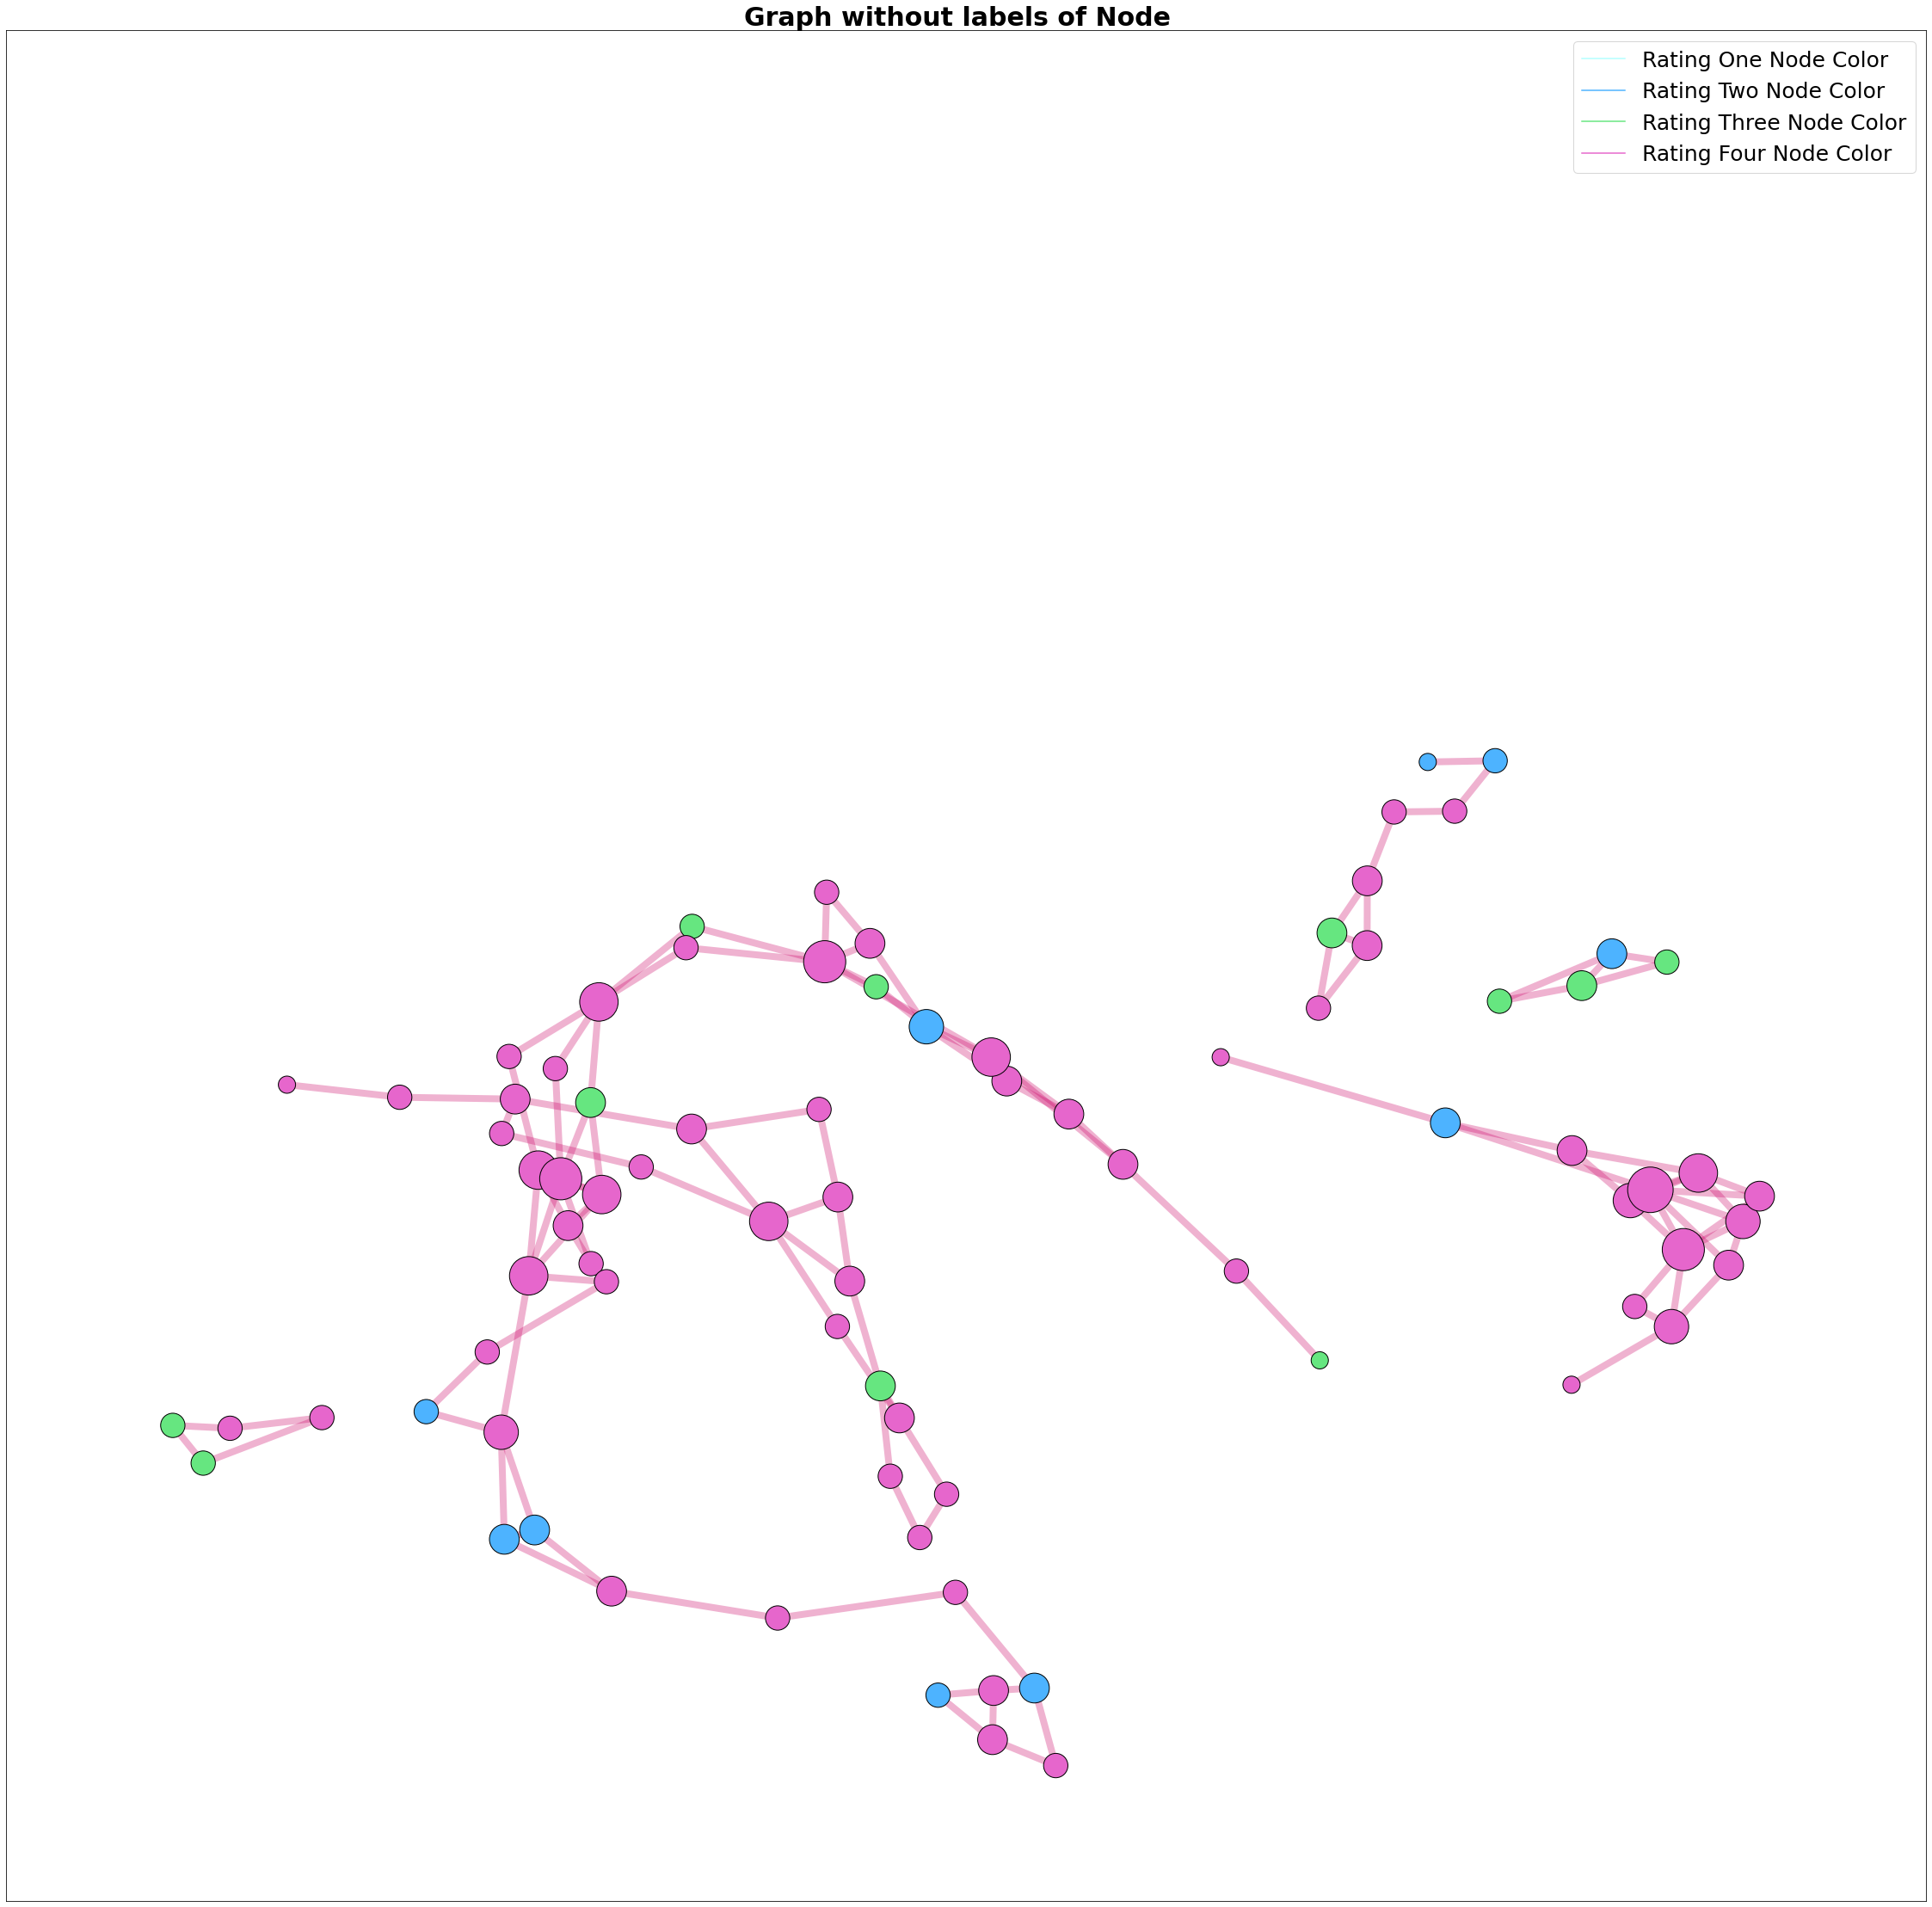

In [26]:
fig, ax = plt.subplots(figsize=(40, 40))
pos = nx.spring_layout(G, k=0.20, seed=10)
a =1
b=2
c=3
d=4
ax.plot(a, color=[0.7,1.0,1.0], label = "Rating One Node Color")
ax.plot(b, color=[0.3,0.7,1.0], label='Rating Two Node Color')
ax.plot(b, color=[0.4,0.9,0.5], label='Rating Three Node Color')
ax.plot(b, color=[0.9,0.4,0.8], label='Rating Four Node Color')

font = {"color": "k", "fontweight": "bold", "fontsize": 30}
ax.set_title("Graph without labels of Node  ", font)
# ax.set_title('Title')
# fig.suptitle('Closeness Centrality', fontsize=34, fontweight='bold')
leg = ax.legend(prop={'size': 25})

d = dict(G.degree)



nx.draw_networkx_nodes(G, pos,nodelist=d.keys(), node_color=list(nx.get_node_attributes(G, 'color').values()), edgecolors='black', node_size=[v * 400 for v in d.values()]) #[v * 100 for v in d.values()]
nx.draw_networkx_edges(G, pos, alpha=0.3, width=8.0, edge_color=nx.get_edge_attributes(G, 'color').values())


# plt.show()

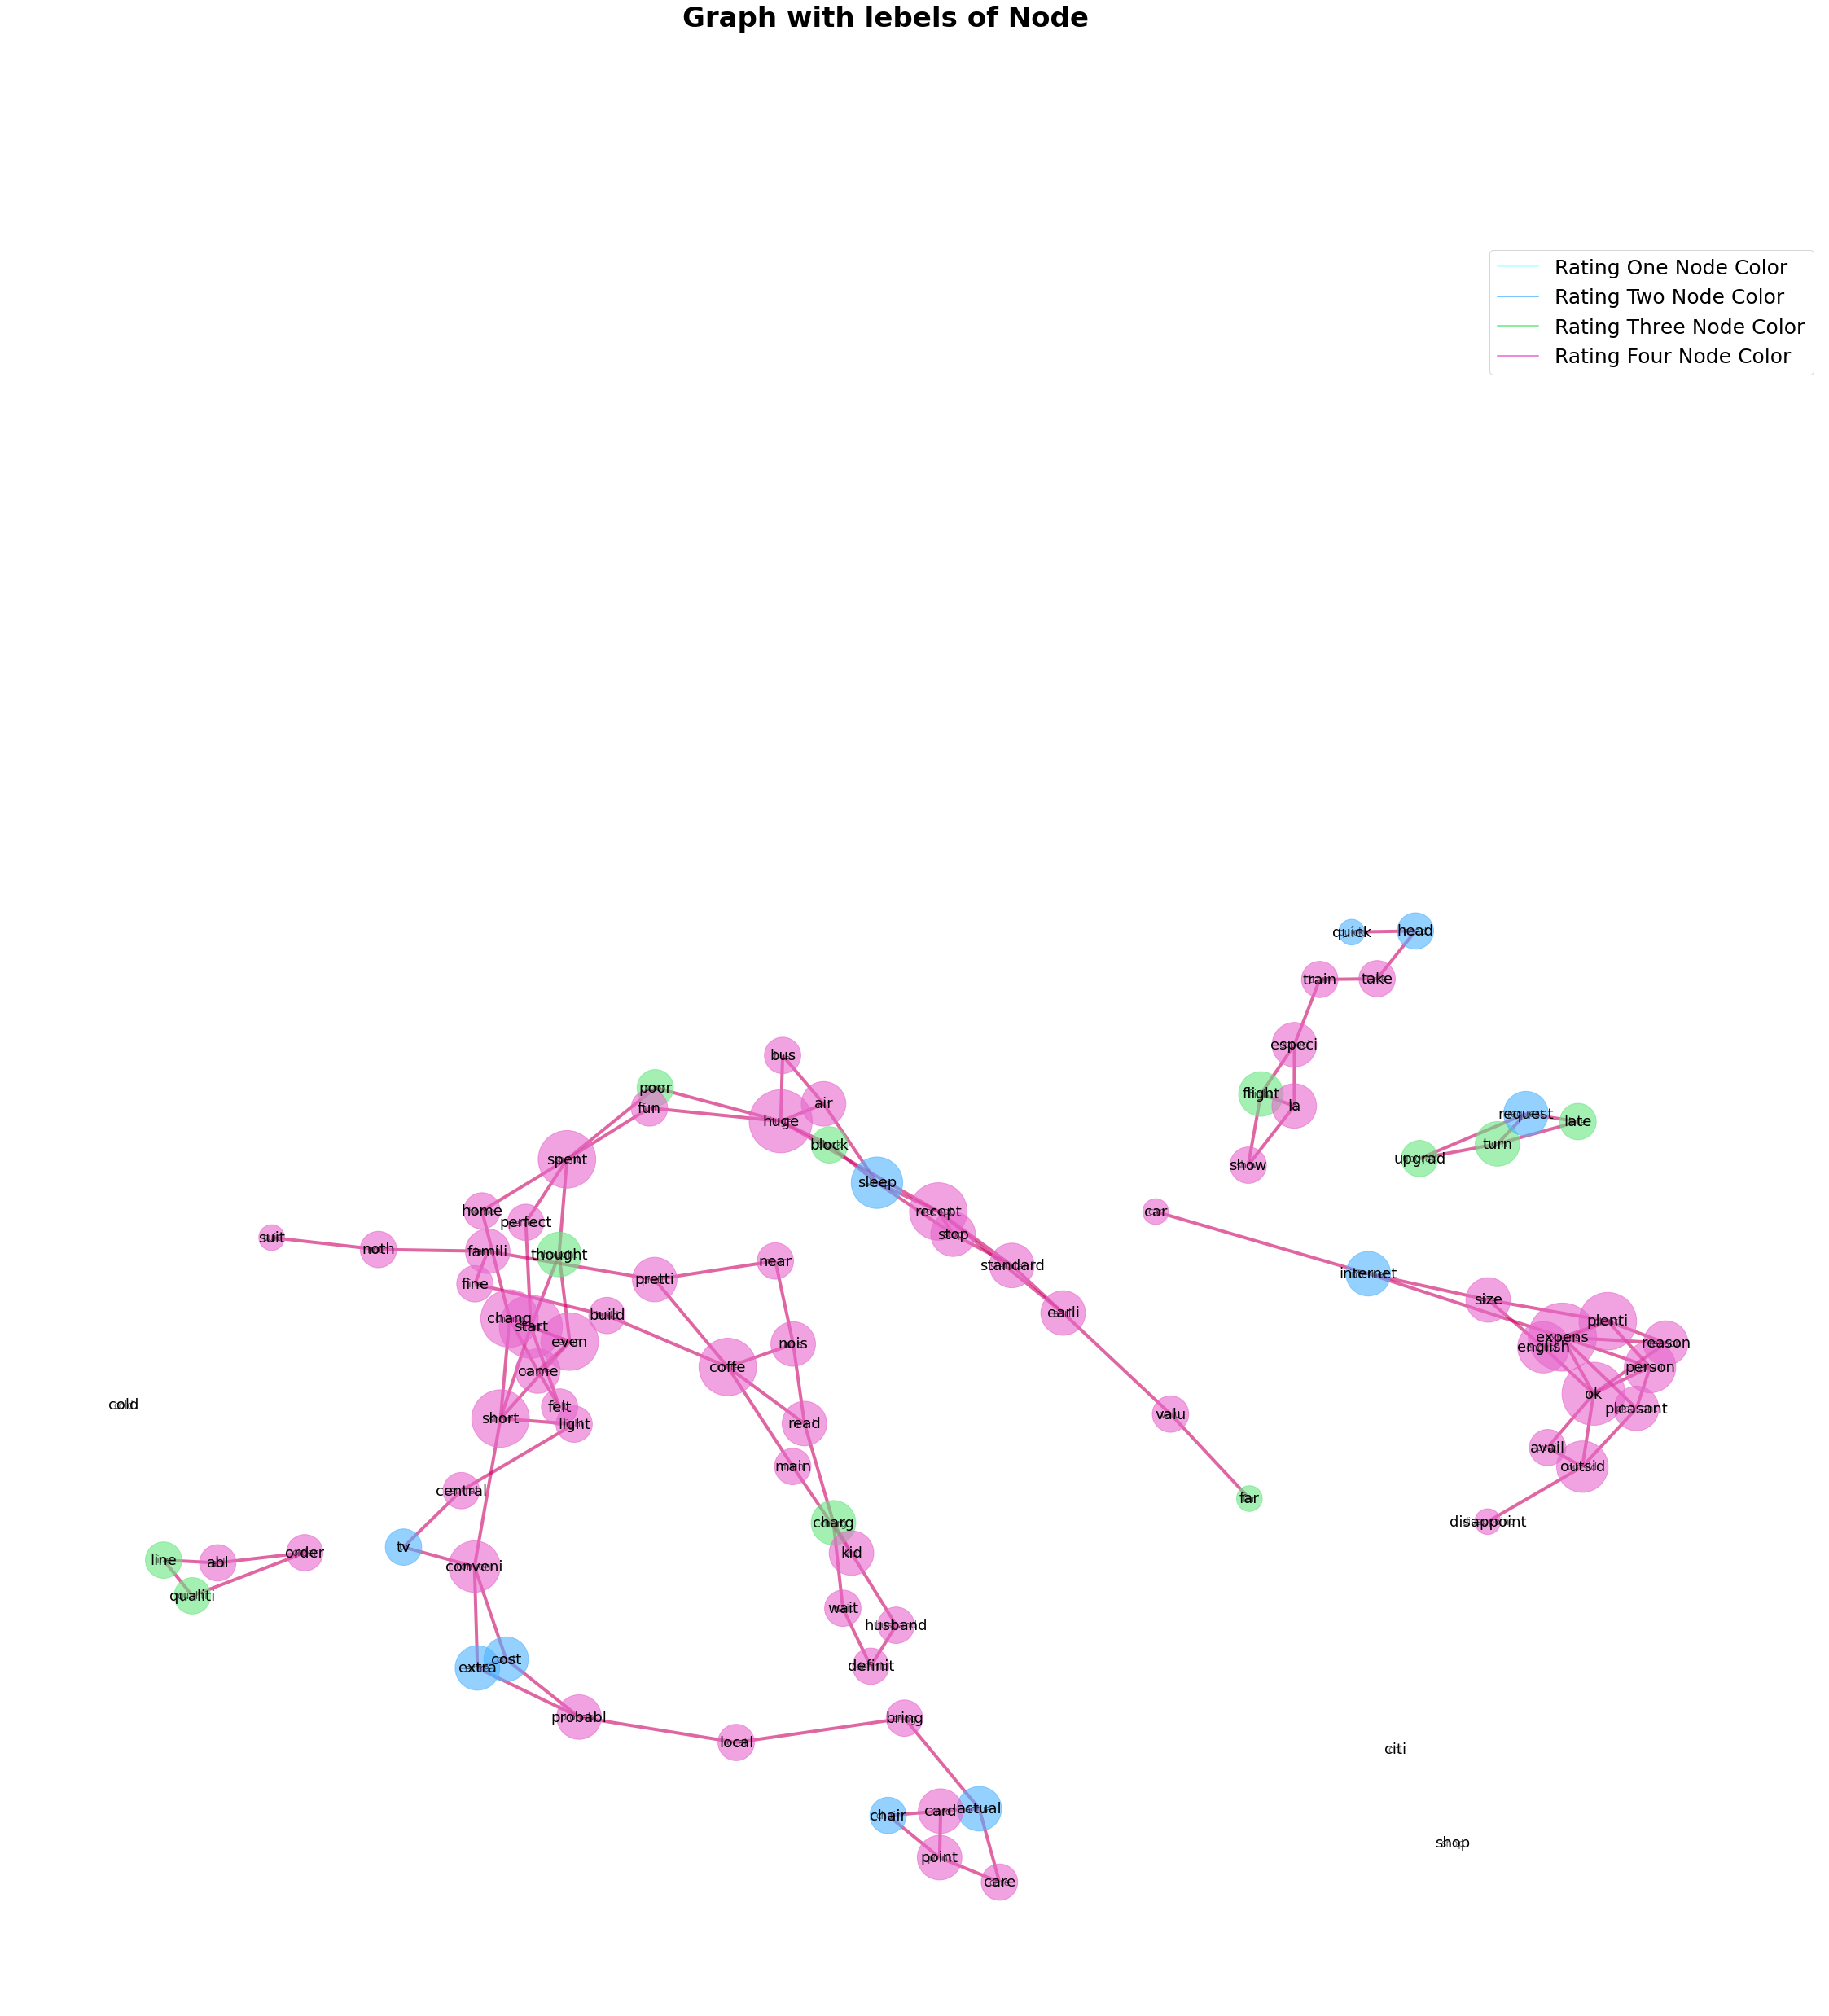

In [47]:
fig, ax = plt.subplots(figsize=(40, 40))
pos = nx.spring_layout(G, k=0.20, seed=10)
a =1
b=2
c=3
d=4
ax.plot(a, color=[0.7,1.0,1.0], label = "Rating One Node Color")
ax.plot(b, color=[0.3,0.7,1.0], label='Rating Two Node Color')
ax.plot(b, color=[0.4,0.9,0.5], label='Rating Three Node Color')
ax.plot(b, color=[0.9,0.4,0.8], label='Rating Four Node Color')

# ax.set_title('Title')
fig.suptitle('Graph with lebels of Node', fontsize=34, fontweight='bold')
leg = ax.legend(prop={'size': 25})
d = dict(G.degree)
nx.draw_networkx_labels(G,pos, font_size=18,font_family='sans-serif')
nx.draw(
    G, 
    pos,
    width=4.0,
    with_labels=True,
    edge_color= list(nx.get_edge_attributes(G, 'color').values()),
    node_color = list(nx.get_node_attributes(G, 'color').values()),
    node_size=[v * 1000 for v in d.values()],
    alpha= 0.6
)



**Degree Centrality**

In [28]:
values=nx.degree_centrality(G)
values = sorted(values.items(), key=lambda x: x[1], reverse=True)
res={}
resDegree={}
for x,y in values:
    res[x]=y*1000
    resDegree[x]=y
resDegree

{'expens': 0.08333333333333333,
 'ok': 0.07142857142857142,
 'huge': 0.07142857142857142,
 'start': 0.07142857142857142,
 'recept': 0.05952380952380952,
 'spent': 0.05952380952380952,
 'chang': 0.05952380952380952,
 'even': 0.05952380952380952,
 'short': 0.05952380952380952,
 'coffe': 0.05952380952380952,
 'plenti': 0.05952380952380952,
 'person': 0.047619047619047616,
 'outsid': 0.047619047619047616,
 'sleep': 0.047619047619047616,
 'english': 0.047619047619047616,
 'conveni': 0.047619047619047616,
 'charg': 0.03571428571428571,
 'read': 0.03571428571428571,
 'internet': 0.03571428571428571,
 'pleasant': 0.03571428571428571,
 'earli': 0.03571428571428571,
 'standard': 0.03571428571428571,
 'stop': 0.03571428571428571,
 'air': 0.03571428571428571,
 'thought': 0.03571428571428571,
 'came': 0.03571428571428571,
 'actual': 0.03571428571428571,
 'turn': 0.03571428571428571,
 'request': 0.03571428571428571,
 'flight': 0.03571428571428571,
 'kid': 0.03571428571428571,
 'nois': 0.035714285714

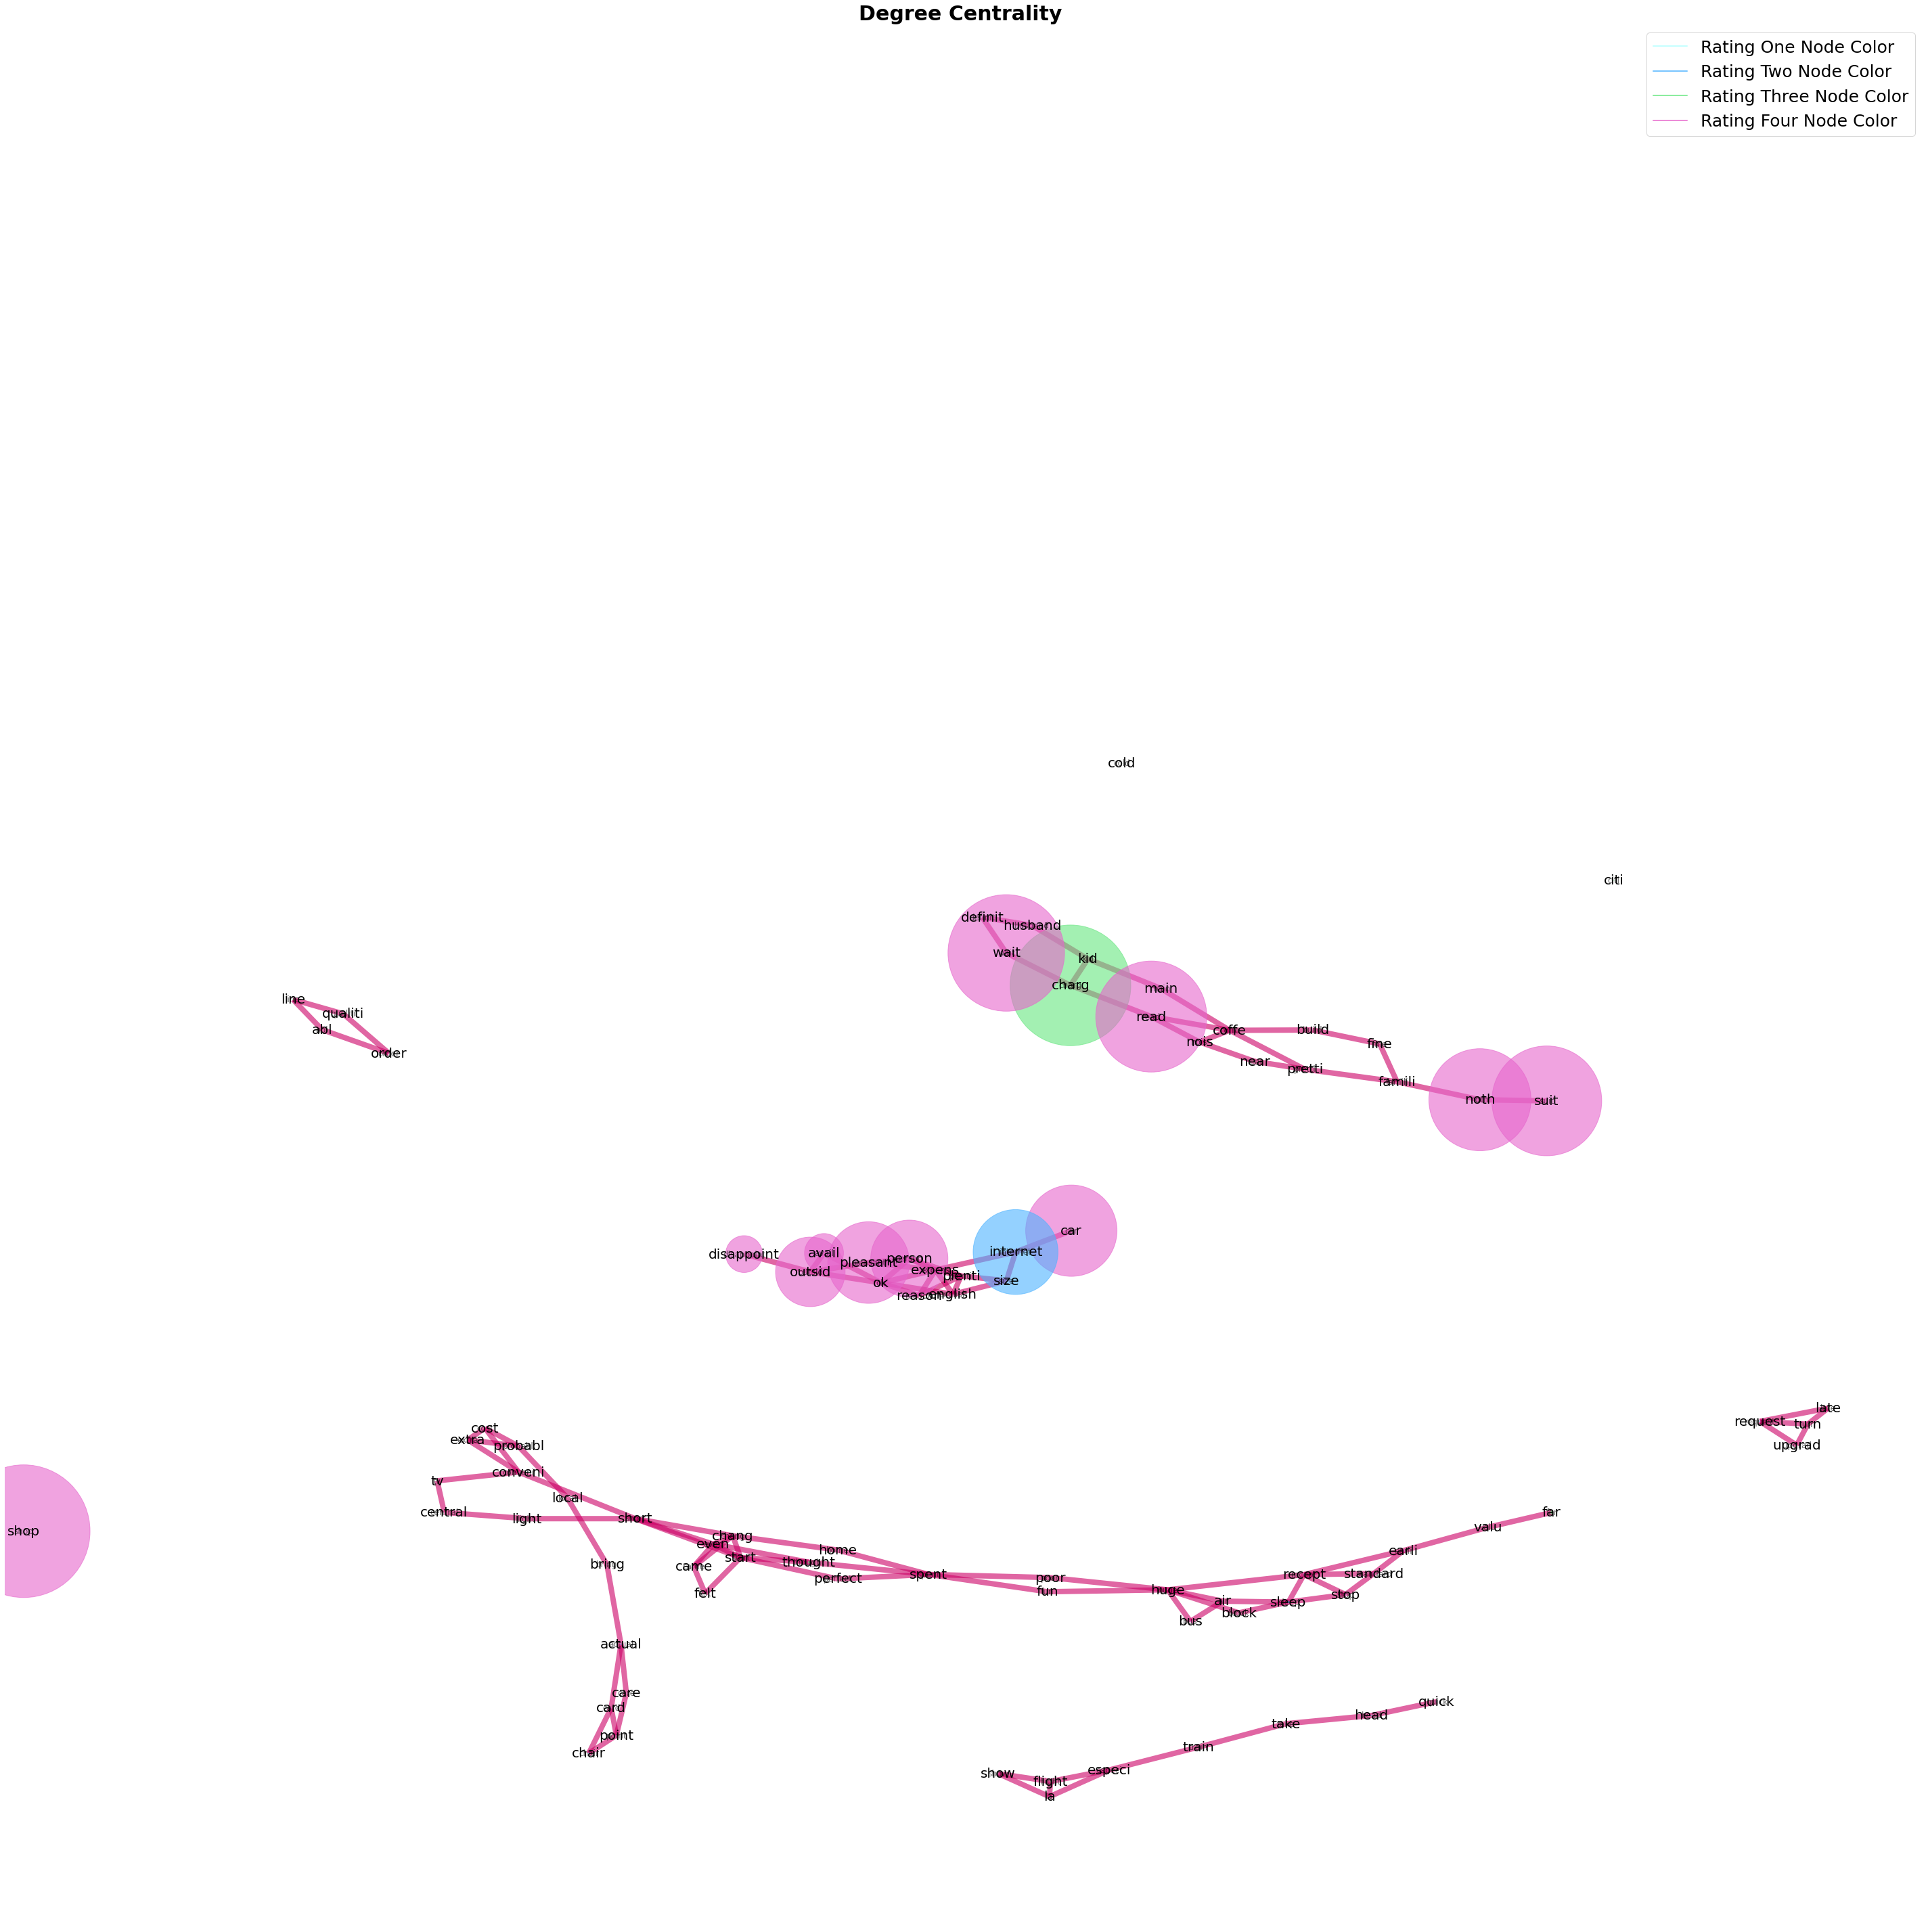

In [52]:
fig, ax = plt.subplots(figsize=(40, 40))
pos = nx.spring_layout(G)


font = {"color": "k", "fontweight": "bold", "fontsize": 30}
ax.set_title("Degree Centrality ", font)
# Change font color for legend
font["color"] = "r"

# ax.text(
#     0.90,
#     0.10,
#     "one star Node colour: SkyBlue",
#     horizontalalignment="center",
#     transform=ax.transAxes,
#     color=[0.1,0.2,0.9],
#     size= 20
#     #fontdict=font,
# )
# ax.text(
#     0.90,
#     0.08,
#     "Two star Node colour: volvet",
#     horizontalalignment="center",
#     transform=ax.transAxes,
#     color=[0.4,0.1,0.6],
#     size= 20
#     #fontdict=font,
# )
# ax.text(
#     0.90,
#     0.06,
#     "Three star Node colour: Green",
#     horizontalalignment="center",
#     transform=ax.transAxes,
#     color=[0.2,0.7,0.1],
#     size= 20
#     #fontdict=font,
# )
# ax.text(
#     0.90,
#     0.04,
#     "Four star Node colour: Red",
#     horizontalalignment="center",
#     transform=ax.transAxes,
#     color=[1,0,0],
#     size= 20
#     #fontdict=font,
# )

a =1
b=2
c=3
d=4
ax.plot(a, color=[0.7,1.0,1.0], label = "Rating One Node Color")
ax.plot(b, color=[0.3,0.7,1.0], label='Rating Two Node Color')
ax.plot(b, color=[0.4,0.9,0.5], label='Rating Three Node Color')
ax.plot(b, color=[0.9,0.4,0.8], label='Rating Four Node Color')

# ax.set_title('Title')
# fig.suptitle('Graph with lebels of Node', fontsize=34, fontweight='bold')
leg = ax.legend(prop={'size': 25})

# Resize figure for label readibility
ax.margins(0.01, 0.05)
fig.tight_layout()
plt.axis("off")
nx.draw_networkx_labels(G,pos, font_size=20,font_family='sans-serif')
nx.draw(
    G, 
    pos,
    width=8.0,
    node_color=list(nx.get_node_attributes(G, 'color').values()),
    edge_color=list(nx.get_edge_attributes(G, 'color').values()),
    node_size=[v * 80 for v in res.values()],
    with_labels=True,
    ax = ax,
    alpha= 0.6
)
plt.show()

**Closeness centrality**

In [30]:
values=nx.closeness_centrality(G)
values = sorted(values.items(), key=lambda x: x[1], reverse=True)
res={}
resCloseness={}
for x,y in values:
    res[x]=y*1000
    resCloseness[x]=y
resCloseness

{'start': 0.10084033613445377,
 'chang': 0.10018552875695733,
 'even': 0.10018552875695733,
 'short': 0.0989010989010989,
 'thought': 0.09827115559599636,
 'home': 0.09703504043126684,
 'perfect': 0.09703504043126684,
 'spent': 0.095829636202307,
 'expens': 0.09523809523809523,
 'conveni': 0.09183673469387754,
 'ok': 0.09022556390977443,
 'poor': 0.08866995073891625,
 'fun': 0.08866995073891625,
 'coffe': 0.08370535714285715,
 'came': 0.0833976833976834,
 'felt': 0.08294930875576036,
 'extra': 0.08294930875576036,
 'cost': 0.08294930875576036,
 'huge': 0.08250572956455308,
 'light': 0.08206686930091185,
 'person': 0.0779220779220779,
 'english': 0.0779220779220779,
 'tv': 0.07714285714285714,
 'probabl': 0.07489597780859916,
 'pleasant': 0.07453416149068322,
 'reason': 0.07453416149068322,
 'read': 0.0744047619047619,
 'recept': 0.07346938775510203,
 'central': 0.07346938775510203,
 'pretti': 0.0723938223938224,
 'plenti': 0.07142857142857142,
 'air': 0.07077326343381389,
 'main': 0.07

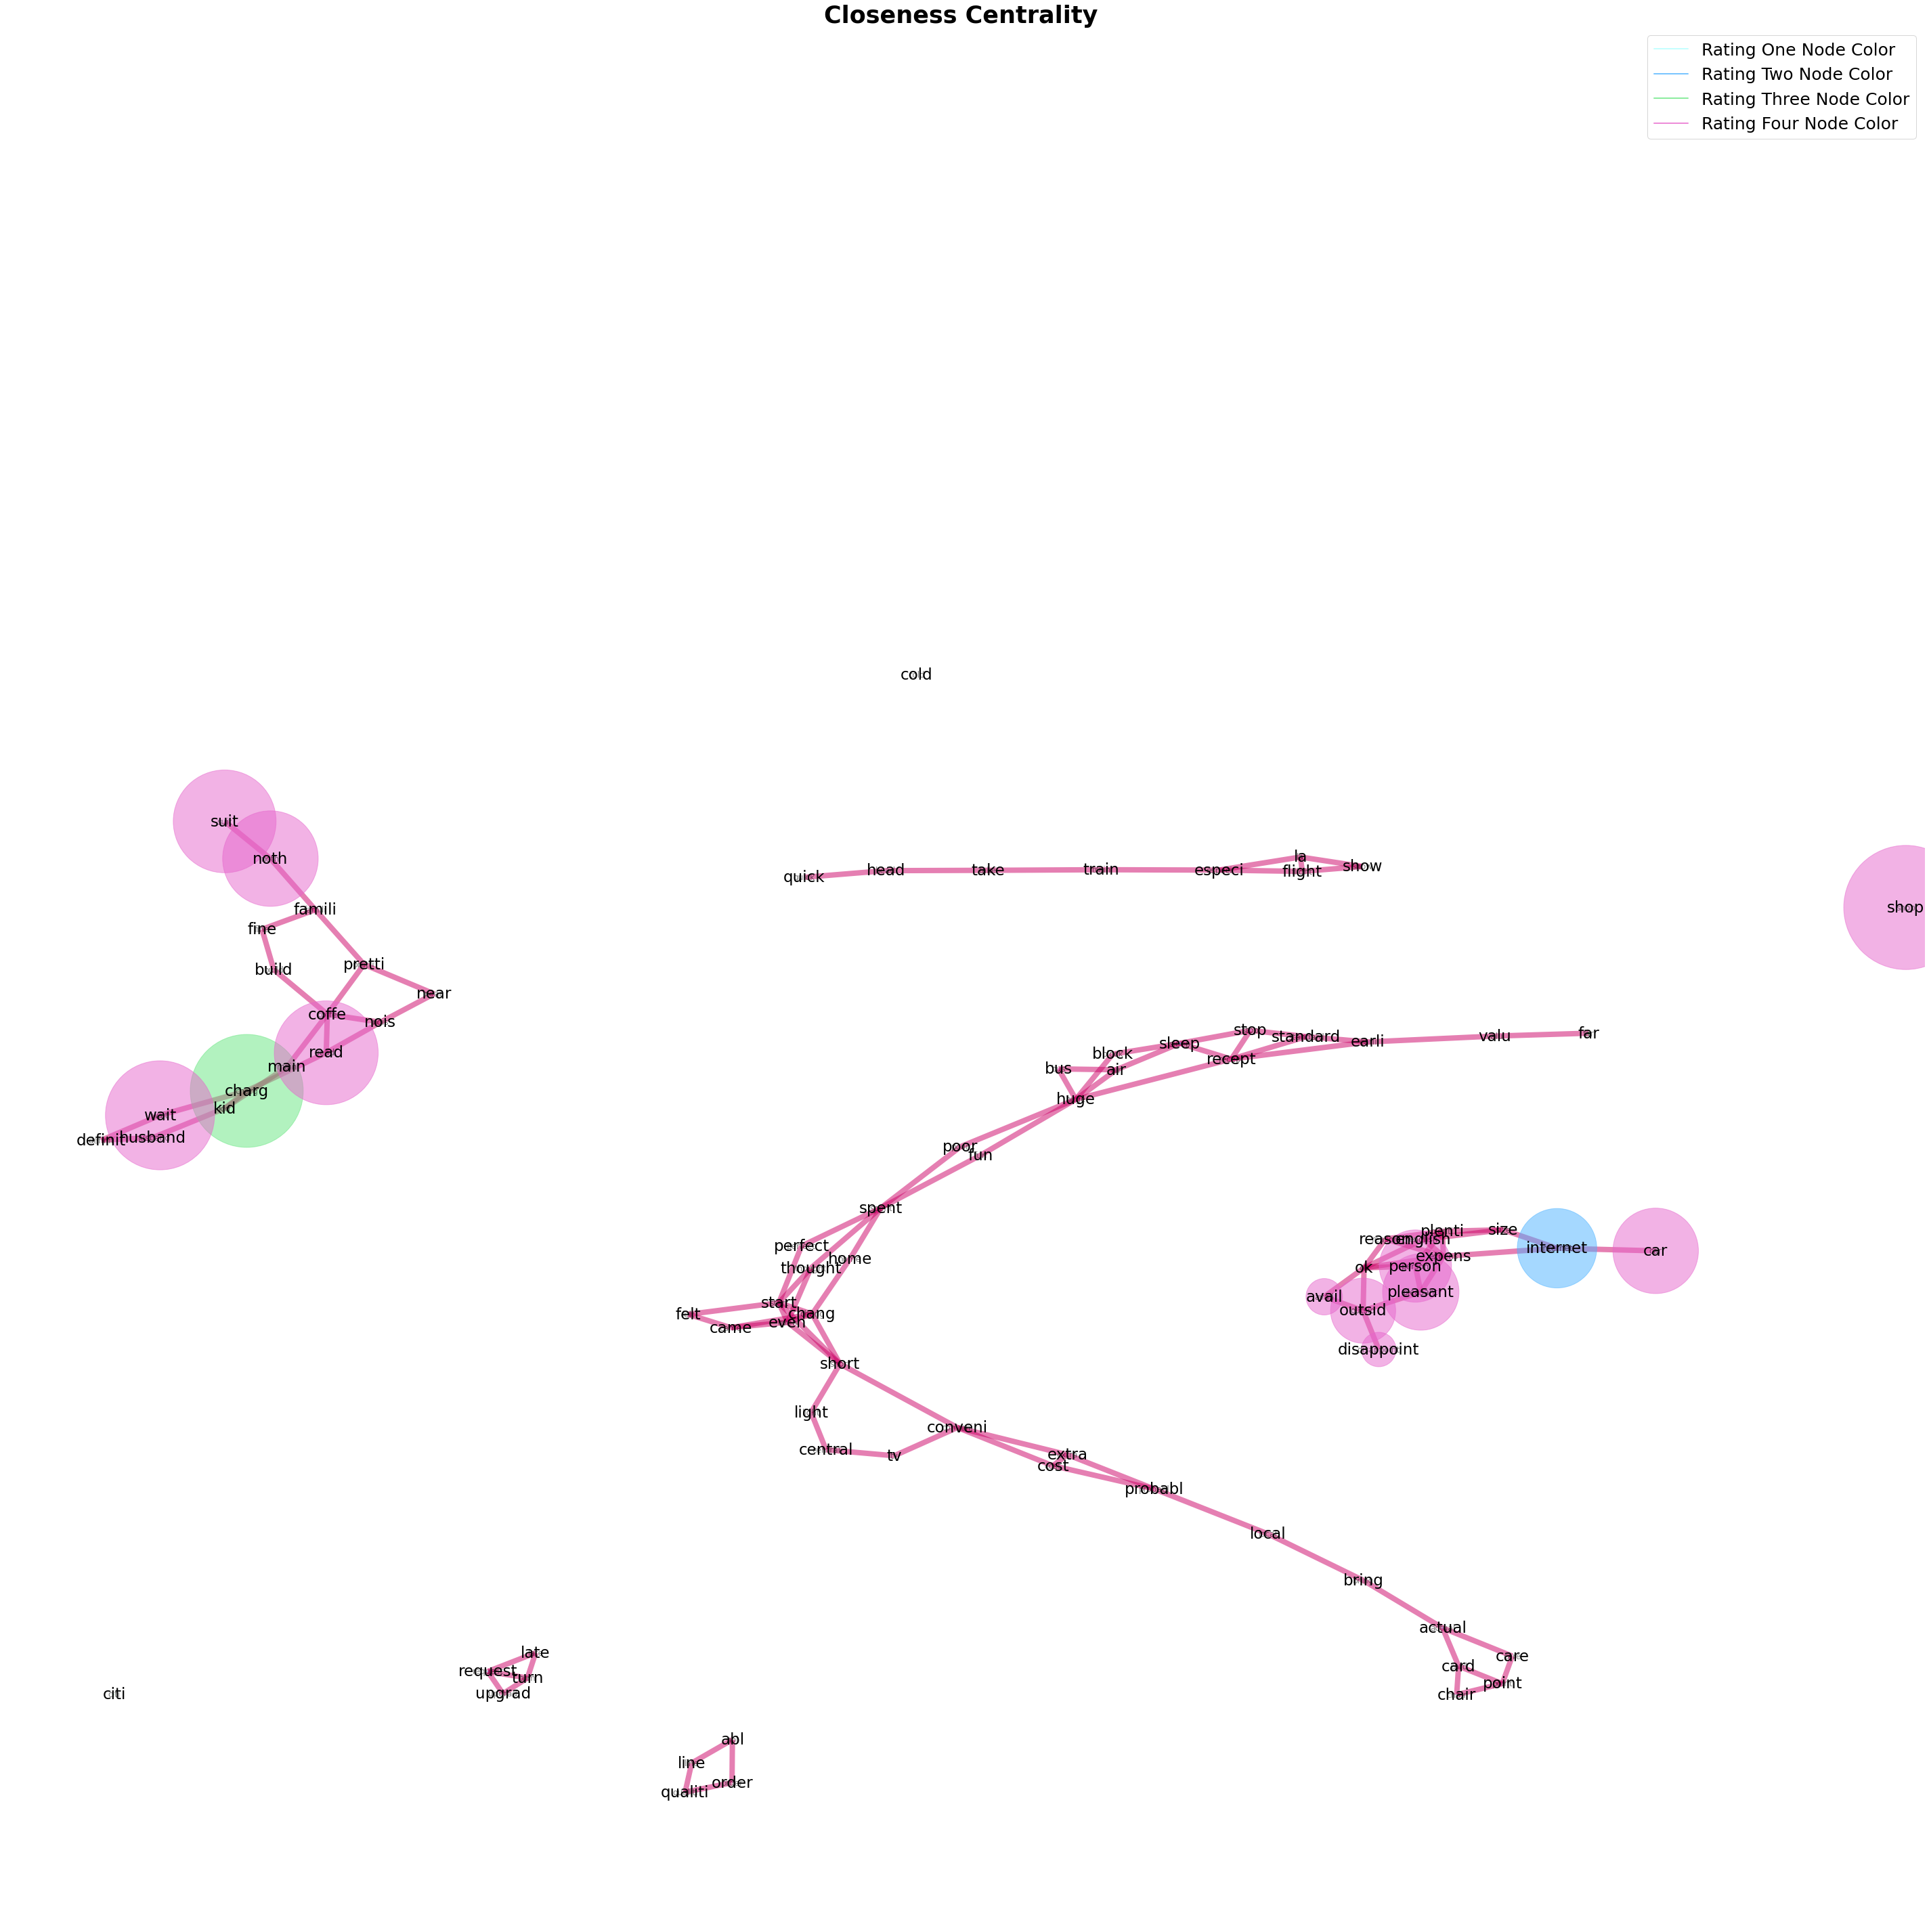

In [53]:
fig, ax = plt.subplots(figsize=(40, 40))
pos = nx.spring_layout(G)


font = {"color": "k", "fontweight": "bold", "fontsize": 35}
ax.set_title("Closeness Centrality ", font)
# Change font color for legend
font["color"] = "r"
a =1
b=2
c=3
d=4
ax.plot(a, color=[0.7,1.0,1.0], label = "Rating One Node Color")
ax.plot(b, color=[0.3,0.7,1.0], label='Rating Two Node Color')
ax.plot(b, color=[0.4,0.9,0.5], label='Rating Three Node Color')
ax.plot(b, color=[0.9,0.4,0.8], label='Rating Four Node Color')

# ax.set_title('Title')
# fig.suptitle('Graph with lebels of Node', fontsize=34, fontweight='bold')
leg = ax.legend(prop={'size': 25})

# Resize figure for label readibility
ax.margins(0.01, 0.05)
fig.tight_layout()
plt.axis("off")

nx.draw_networkx_labels(G,pos, font_size=23,font_family='sans-serif')
nx.draw(
    G, 
    pos = pos,
    width=8.0,
    node_color=list(nx.get_node_attributes(G, 'color').values()),
    edge_color=list(nx.get_edge_attributes(G, 'color').values()),
    node_size=[v * 70 for v in res.values()],
    with_labels=True,
    alpha=0.5
)

plt.show()

**Betweenness centrality**

In [32]:
values=nx.betweenness_centrality(G,normalized=True)
values = sorted(values.items(), key=lambda x: x[1], reverse=True)
res={}
resBetweenness={}
resBetweenness={}
for x,y in values:
    res[x]=y*1000
    resBetweenness[x]=y
resBetweenness

{'short': 0.09150889271371199,
 'spent': 0.08663224325874927,
 'conveni': 0.08118187033849683,
 'huge': 0.07807420156817746,
 'probabl': 0.058232931726907626,
 'local': 0.05163511187607572,
 'start': 0.04704532415375788,
 'recept': 0.046136928667049146,
 'bring': 0.0444635685599541,
 'thought': 0.040160642570281124,
 'poor': 0.037865748709122196,
 'fun': 0.037865748709122196,
 'actual': 0.03686173264486517,
 'extra': 0.030981067125645436,
 'cost': 0.030981067125645436,
 'chang': 0.02486135016255498,
 'even': 0.02199273283610633,
 'home': 0.02108433734939759,
 'earli': 0.01950659781985083,
 'perfect': 0.019076305220883532,
 'coffe': 0.01529929240772614,
 'card': 0.014199655765920825,
 'valu': 0.010040160642570281,
 'pretti': 0.009514247466054695,
 'famili': 0.008032128514056224,
 'read': 0.007219353604895772,
 'light': 0.006597819850831898,
 'charg': 0.0063587684069611764,
 'expens': 0.006239242685025816,
 'ok': 0.005832855230445592,
 'main': 0.00568942436412316,
 'kid': 0.0053069420539

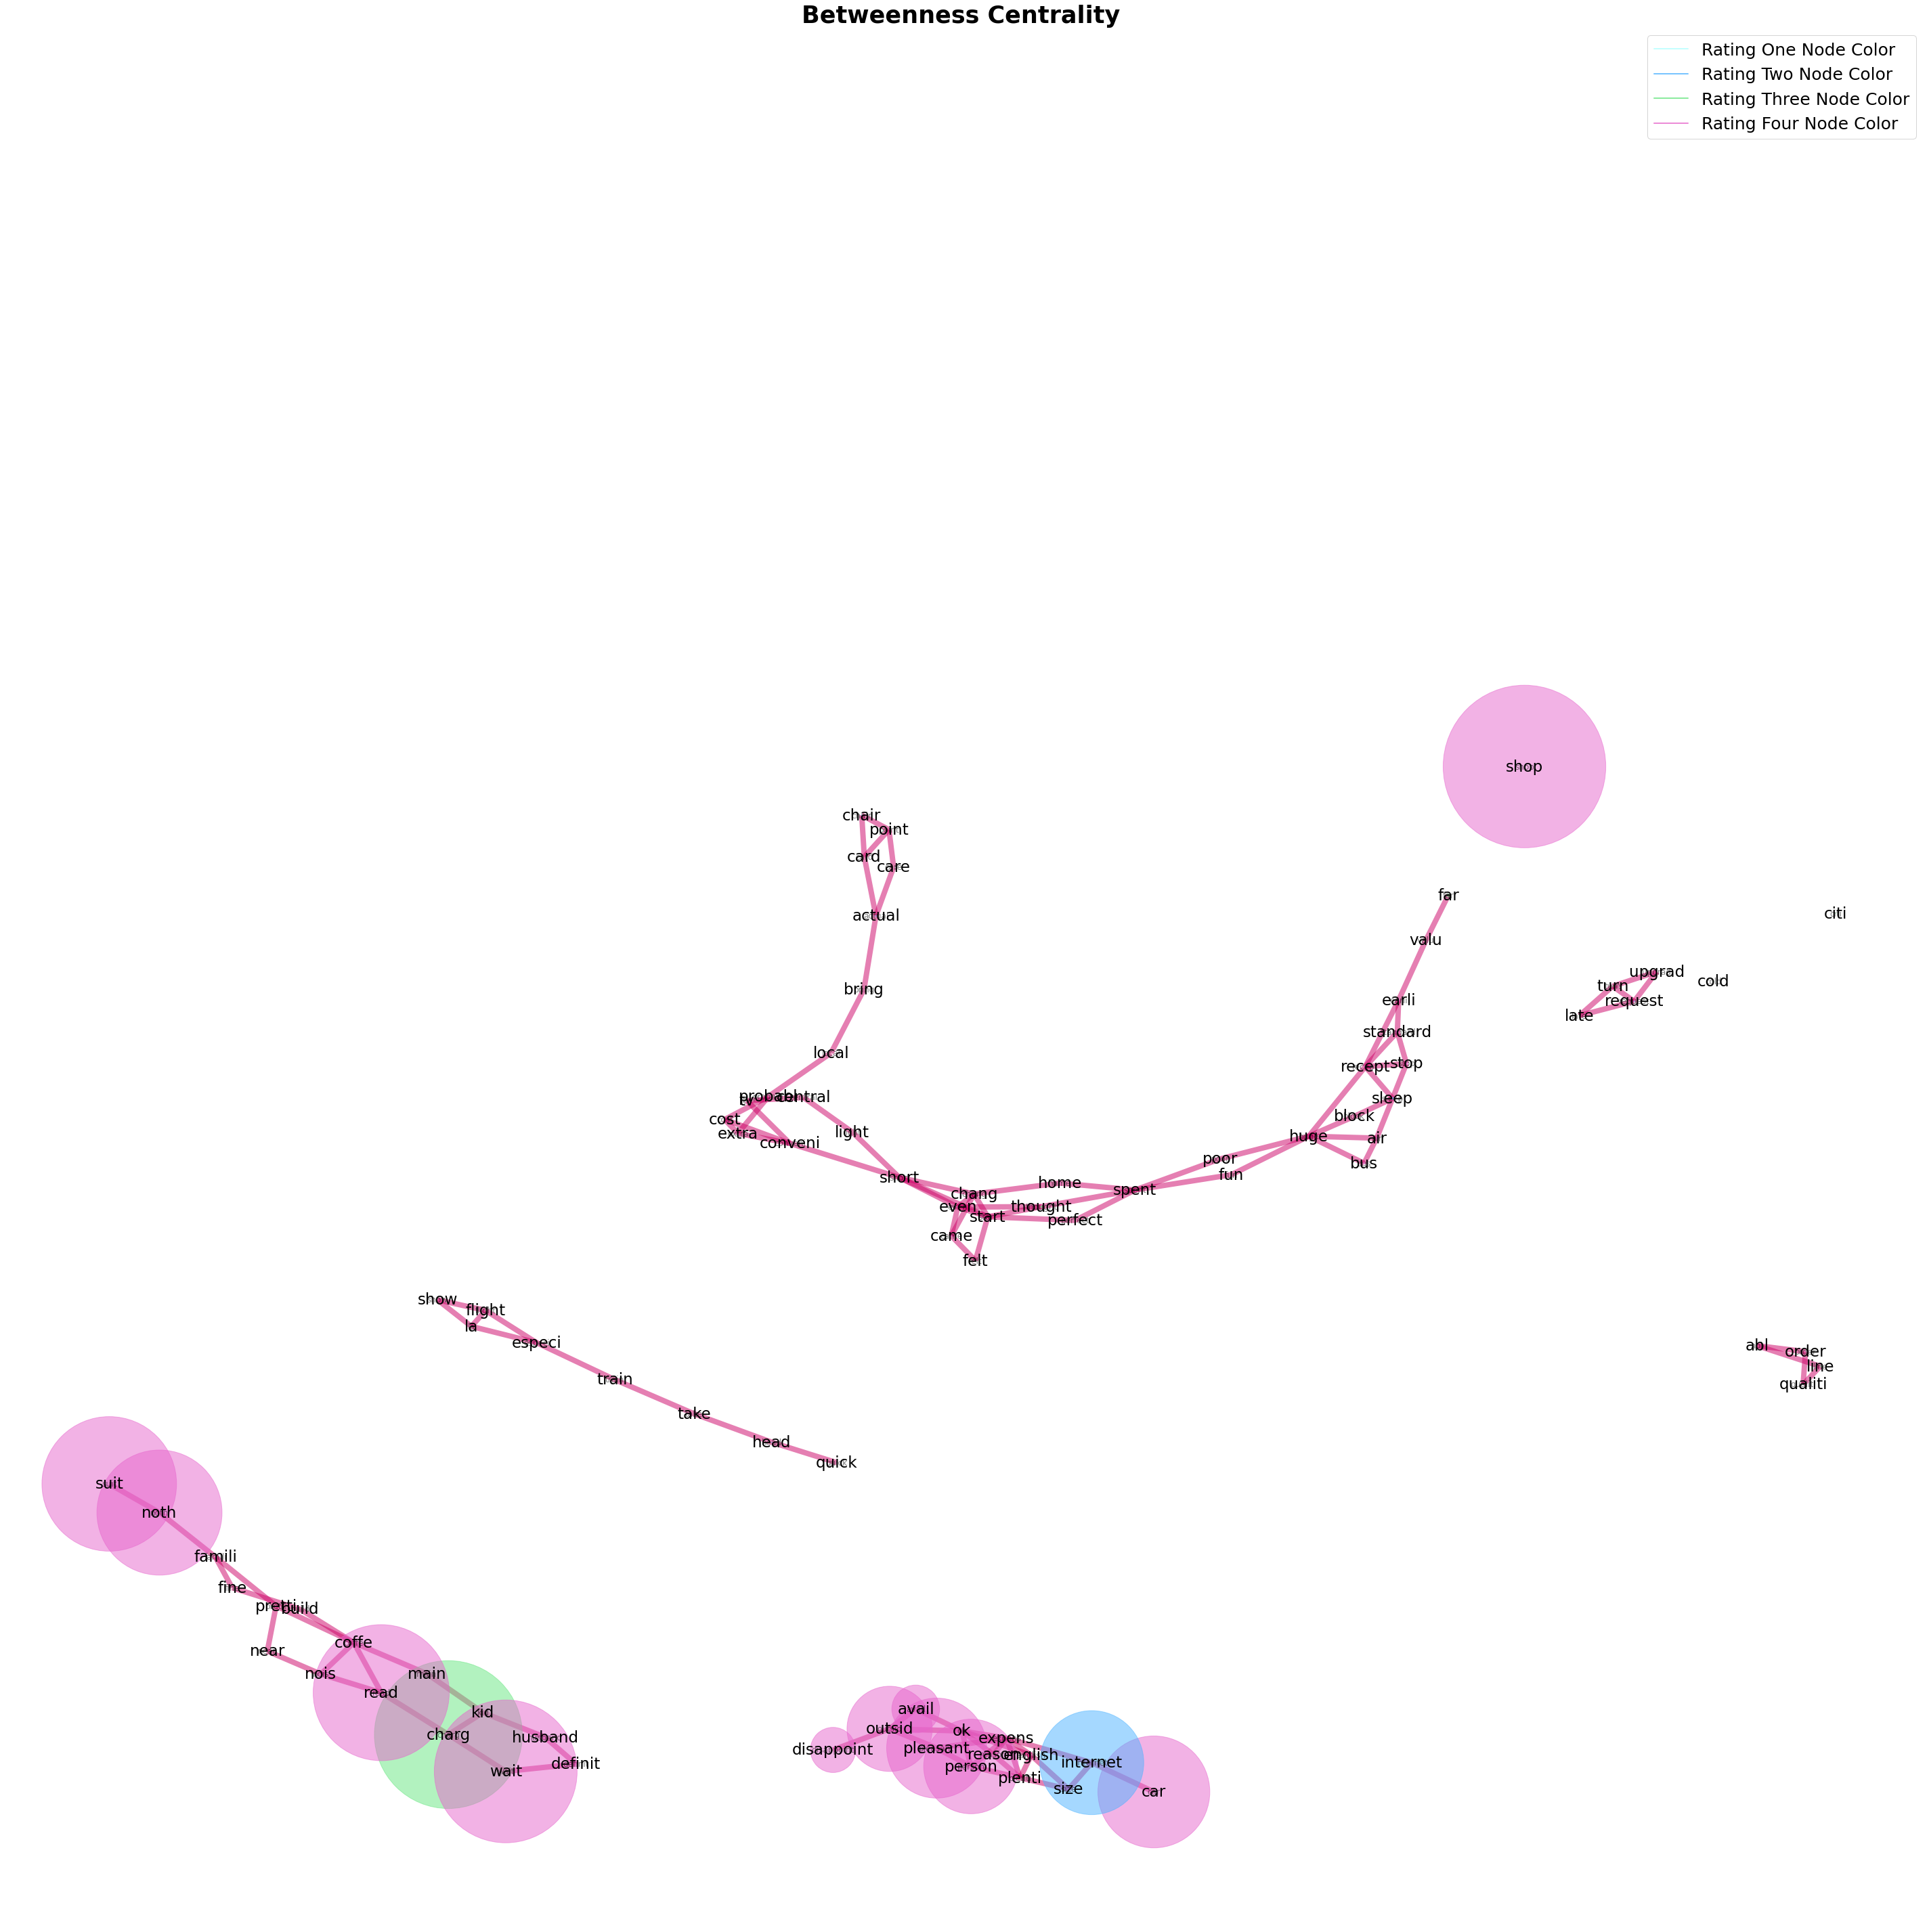

In [57]:
fig, ax = plt.subplots(figsize=(40, 40))
pos = nx.spring_layout(G)


font = {"color": "k", "fontweight": "bold", "fontsize": 35}
ax.set_title("Betweenness Centrality ", font)
# Change font color for legend
font["color"] = "r"
a =1
b=2
c=3
d=4
ax.plot(a, color=[0.7,1.0,1.0], label = "Rating One Node Color")
ax.plot(b, color=[0.3,0.7,1.0], label='Rating Two Node Color')
ax.plot(b, color=[0.4,0.9,0.5], label='Rating Three Node Color')
ax.plot(b, color=[0.9,0.4,0.8], label='Rating Four Node Color')

# ax.set_title('Title')
# fig.suptitle('Graph with lebels of Node', fontsize=34, fontweight='bold')
leg = ax.legend(prop={'size': 25})

# Resize figure for label readibility
ax.margins(0.01, 0.05)
fig.tight_layout()
plt.axis("off")

nx.draw_networkx_labels(G,pos, font_size=23,font_family='sans-serif')

nx.draw_networkx(
    G, 
    pos,
    width=8.0,
    node_color=list(nx.get_node_attributes(G, 'color').values()),
    edge_color=list(nx.get_edge_attributes(G, 'color').values()),
    node_size=[v * 120 for v in res.values()],
    with_labels=True,
    alpha = 0.5
)
plt.show()

**EigenVector centrality**

In [34]:

values=nx.eigenvector_centrality(G, max_iter=1000)
values = sorted(values.items(), key=lambda x: x[1], reverse=True)
res={}
resEigenvector={}
for x,y in values:
    res[x]=y*1000
    resEigenvector[x]=y
resEigenvector

{'expens': 0.480611963882833,
 'ok': 0.39762759140552223,
 'plenti': 0.3708717405578486,
 'person': 0.3364704280948713,
 'english': 0.32940770186500506,
 'reason': 0.2846043576215834,
 'pleasant': 0.22763704337050514,
 'size': 0.19663916552028154,
 'outsid': 0.18200281038311317,
 'internet': 0.16275795064384935,
 'avail': 0.13206616472653063,
 'disappoint': 0.041468516942133625,
 'car': 0.03708366271671396,
 'start': 0.00014422348028410124,
 'even': 0.00013957040960437485,
 'chang': 0.00013209106987724338,
 'short': 0.00012171548273422508,
 'thought': 8.33614860725434e-05,
 'came': 8.126231329156493e-05,
 'felt': 5.5933404676192385e-05,
 'spent': 5.2263434920956756e-05,
 'perfect': 4.8740022476145874e-05,
 'home': 4.5730488969033934e-05,
 'conveni': 4.175217359121463e-05,
 'light': 3.3037668751342425e-05,
 'extra': 1.669948133970761e-05,
 'cost': 1.669948133970761e-05,
 'poor': 1.6429460197799103e-05,
 'fun': 1.6429460197799103e-05,
 'huge': 1.3969034374965762e-05,
 'tv': 1.32021835042

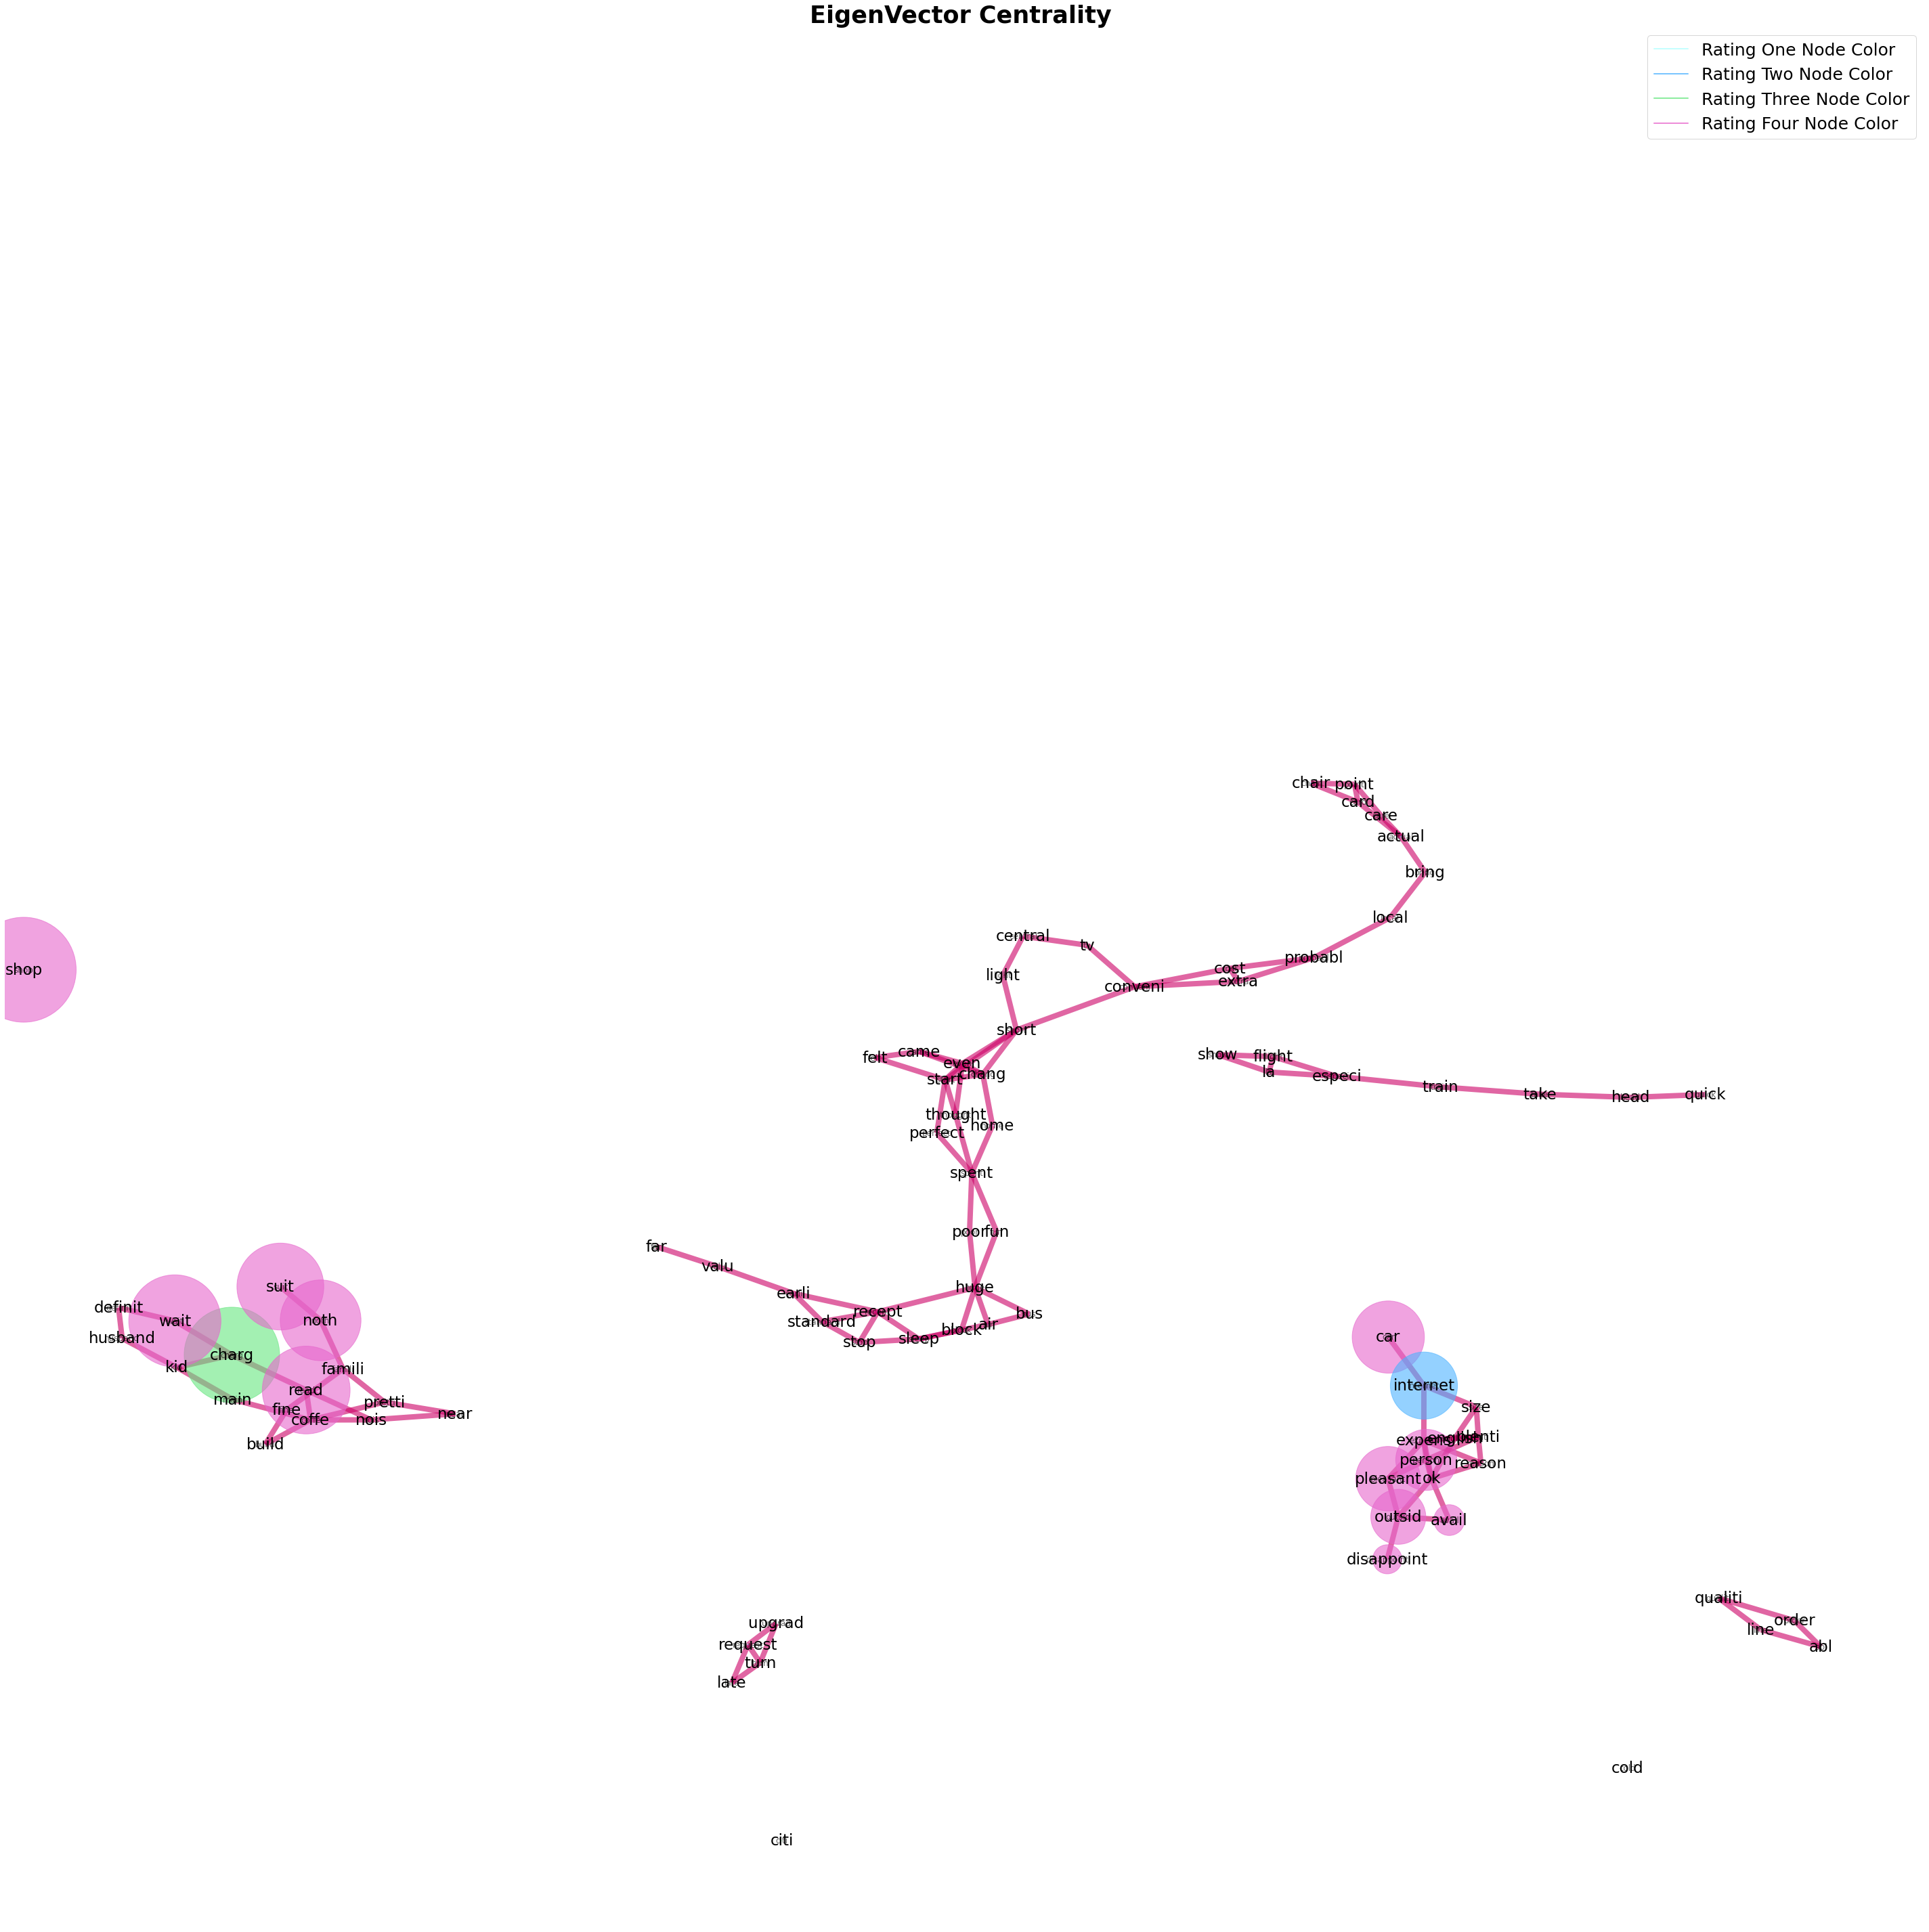

In [58]:
fig, ax = plt.subplots(figsize=(40, 40))
pos = nx.spring_layout(G)


font = {"color": "k", "fontweight": "bold", "fontsize": 35}
ax.set_title("EigenVector Centrality ", font)
# Change font color for legend
font["color"] = "r"
a =1
b=2
c=3
d=4
ax.plot(a, color=[0.7,1.0,1.0], label = "Rating One Node Color")
ax.plot(b, color=[0.3,0.7,1.0], label='Rating Two Node Color')
ax.plot(b, color=[0.4,0.9,0.5], label='Rating Three Node Color')
ax.plot(b, color=[0.9,0.4,0.8], label='Rating Four Node Color')

# ax.set_title('Title')
# fig.suptitle('Graph with lebels of Node', fontsize=34, fontweight='bold')
leg = ax.legend(prop={'size': 25})

# Resize figure for label readibility
ax.margins(0.01, 0.05)
fig.tight_layout()
plt.axis("off")

nx.draw_networkx_labels(G,pos, font_size=23,font_family='sans-serif')

nx.draw(
    G, 
    pos,
    width=8.0,
    node_color=list(nx.get_node_attributes(G, 'color').values()),
    edge_color=list(nx.get_edge_attributes(G, 'color').values()),
    node_size=[v * 50 for v in res.values()],
    with_labels=True,
    alpha = 0.6
)
plt.show()

**Comparison centralities**

In [36]:
closeness=[]
betweenness=[]
degreeC=[]
eigenvectorC=[]

closeness=[resCloseness[i] for i in resCloseness]
betweenness=[resBetweenness[i] for i in resBetweenness]
degreeC=[resDegree[i] for i in resDegree]
eigenvectorC=[resEigenvector[i] for i in resEigenvector]


data={'Degree':np.array(degreeC),'Closeness':np.array(closeness),'betweenness': np.array(betweenness),'EigenVector Centrality':np.array(eigenvectorC)}
pd.DataFrame.from_dict(data)

,Degree,Closeness,betweenness,EigenVector Centrality
0,0.083333,0.100840,0.091509,4.806120e-01
1,0.071429,0.100186,0.086632,3.976276e-01
2,0.071429,0.100186,0.081182,3.708717e-01
3,0.071429,0.098901,0.078074,3.364704e-01
4,0.059524,0.098271,0.058233,3.294077e-01
...,...,...,...,...
80,0.011905,0.026515,0.000000,1.683494e-31
81,0.011905,0.022436,0.000000,1.683494e-31
82,0.000000,0.000000,0.000000,2.810491e-88
83,0.000000,0.000000,0.000000,2.810491e-88


**As we can see the node expens may be the most important because is the most important node in closenness centrality and eigenvector centrality, also, It is the second most important node in degree centrality**



In [37]:
closeness=[]
betweenness=[]
degreeC=[]
eigenvectorC=[]

closeness=[i for i in resCloseness]
betweenness=[i for i in resBetweenness]
degreeC=[i for i in resDegree]
eigenvectorC=[i for i in resEigenvector]


data={'Degree':np.array(degreeC),'Closeness':np.array(closeness),'betweenness': np.array(betweenness),'EigenVector Centrality':np.array(eigenvectorC)}
pd.DataFrame.from_dict(data)

,Degree,Closeness,betweenness,EigenVector Centrality
0,expens,start,short,expens
1,ok,chang,spent,ok
2,huge,even,conveni,plenti
3,start,short,huge,person
4,recept,thought,probabl,english
...,...,...,...,...
80,far,show,show,order
81,quick,quick,citi,abl
82,shop,shop,chair,shop
83,cold,cold,upgrad,cold


In [38]:
#connected component
components = nx.connected_components(G)

In [39]:
# largest connected component
largest_component = max(components, key=len)
H = G.subgraph(largest_component)

In [40]:
# compute centrality
centrality = nx.betweenness_centrality(H, k=10, endpoints=True)

In [41]:
# compute community structure
lpc = nx.community.label_propagation_communities(H)
community_index = {n: i for i, com in enumerate(lpc) for n in com}

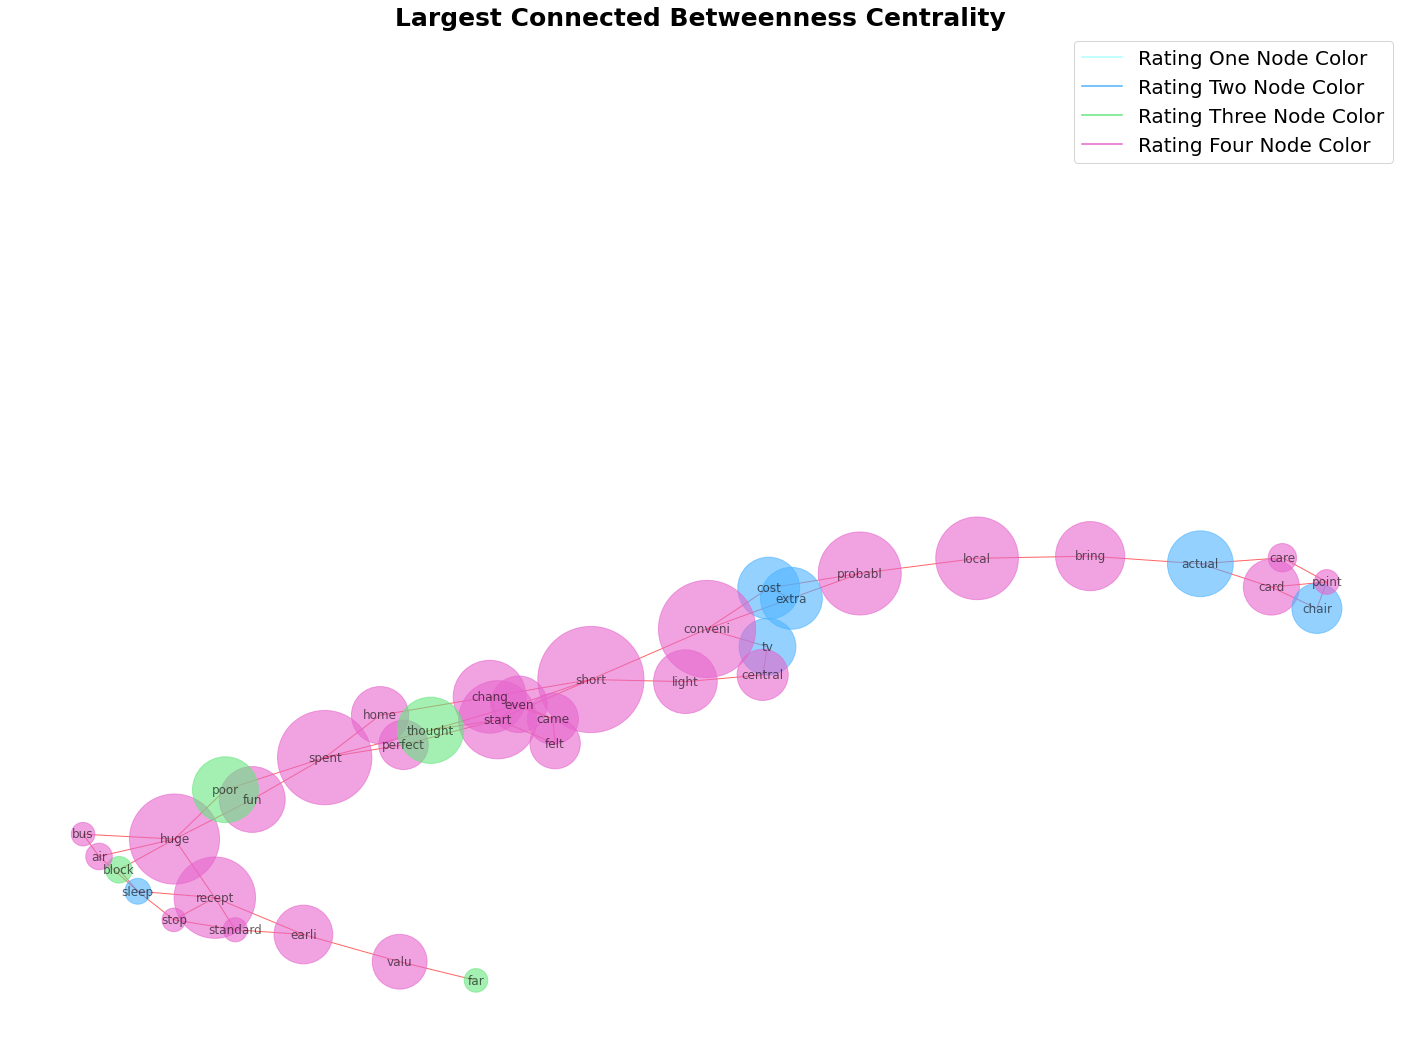

In [43]:
#### draw graph ####

fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(H, k=0.15, seed=42)
font = {"color": "k", "fontweight": "bold", "fontsize": 25}
ax.set_title("Largest Connected Betweenness Centrality ", font)
# Change font color for legend
font["color"] = "r"
a =1
b=2
c=3
d=4
ax.plot(a, color=[0.7,1.0,1.0], label = "Rating One Node Color")
ax.plot(b, color=[0.3,0.7,1.0], label='Rating Two Node Color')
ax.plot(b, color=[0.4,0.9,0.5], label='Rating Three Node Color')
ax.plot(b, color=[0.9,0.4,0.8], label='Rating Four Node Color')

# ax.set_title('Title')
# fig.suptitle('Graph with lebels of Node', fontsize=34, fontweight='bold')
leg = ax.legend(prop={'size': 20})

# Resize figure for label readibility
ax.margins(0.01, 0.05)
fig.tight_layout()
plt.axis("off")
# node_color = [community_index[n] for n in H]
node_size = [v * 20000 for v in centrality.values()]

nx.draw_networkx(
    H,
    pos=pos,
    with_labels=True,
    node_color=list(nx.get_node_attributes(H, 'color').values()),
    node_size=node_size,
    edge_color="r",
    alpha=0.6,
)

plt.show()